In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Cek versi library untuk kompatibilitas
!pip show pandas matplotlib seaborn scikit-learn xgboost

Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License
        
        Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
        All rights reserved.
        
        Copyright (c) 2011-2023, Open source contributors.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          and/or other materials 

In [2]:
# Definisikan nama kolom
columns = [
    "Class", "Alcohol", "Malic_acid", "Ash", "Alcalinity_of_ash", "Magnesium",
    "Total_phenols", "Flavanoids", "Nonflavanoid_phenols", "Proanthocyanins",
    "Color_intensity", "Hue", "OD280/OD315", "Proline"
]

# Load dataset
url_data = 'wine.data'  # Ganti dengan path file dataset Anda
data = pd.read_csv(url_data, header=None, names=columns)

# Tampilkan 5 baris pertama
print(data.head())

# Periksa informasi dataset
print(data.info())

# Periksa statistik deskriptif
print(data.describe())

   Class  Alcohol  Malic_acid   Ash  Alcalinity_of_ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color_intensity   Hue  OD280/OD315  Proline  
0             5.64  1.04         3.92     1065  
1             4.38  1.05         3.40     1050  
2          

Missing Values:
 Class                   0
Alcohol                 0
Malic_acid              0
Ash                     0
Alcalinity_of_ash       0
Magnesium               0
Total_phenols           0
Flavanoids              0
Nonflavanoid_phenols    0
Proanthocyanins         0
Color_intensity         0
Hue                     0
OD280/OD315             0
Proline                 0
dtype: int64


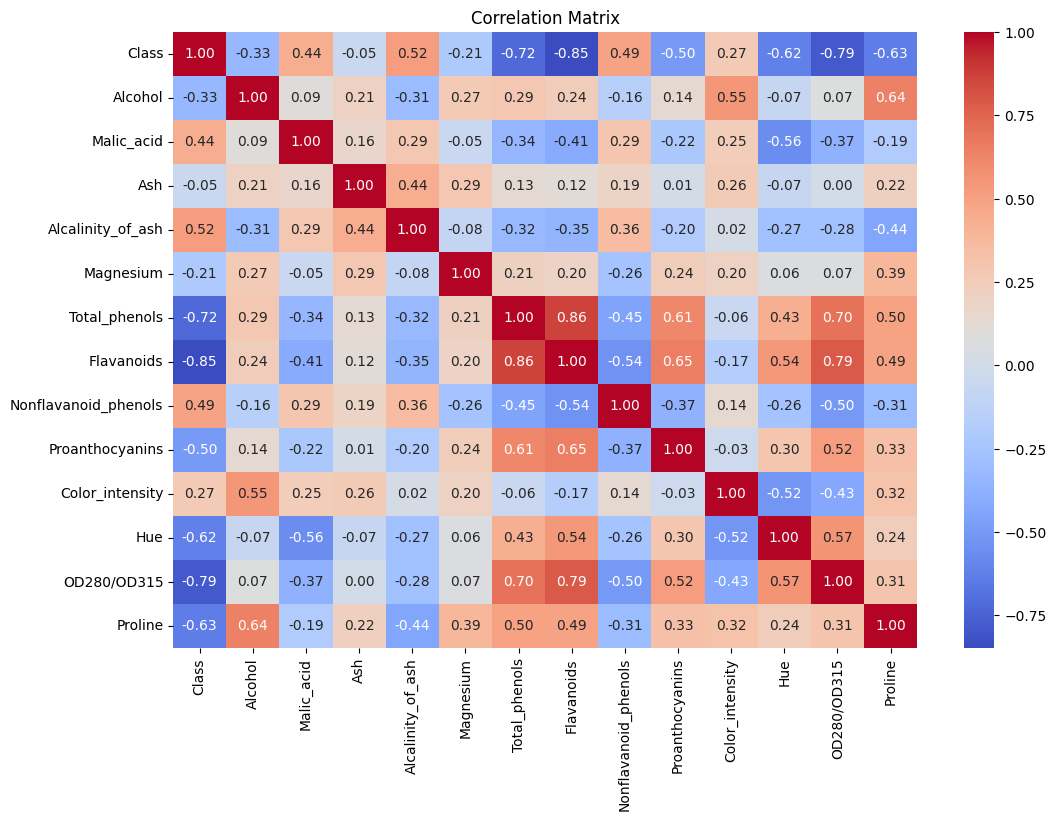

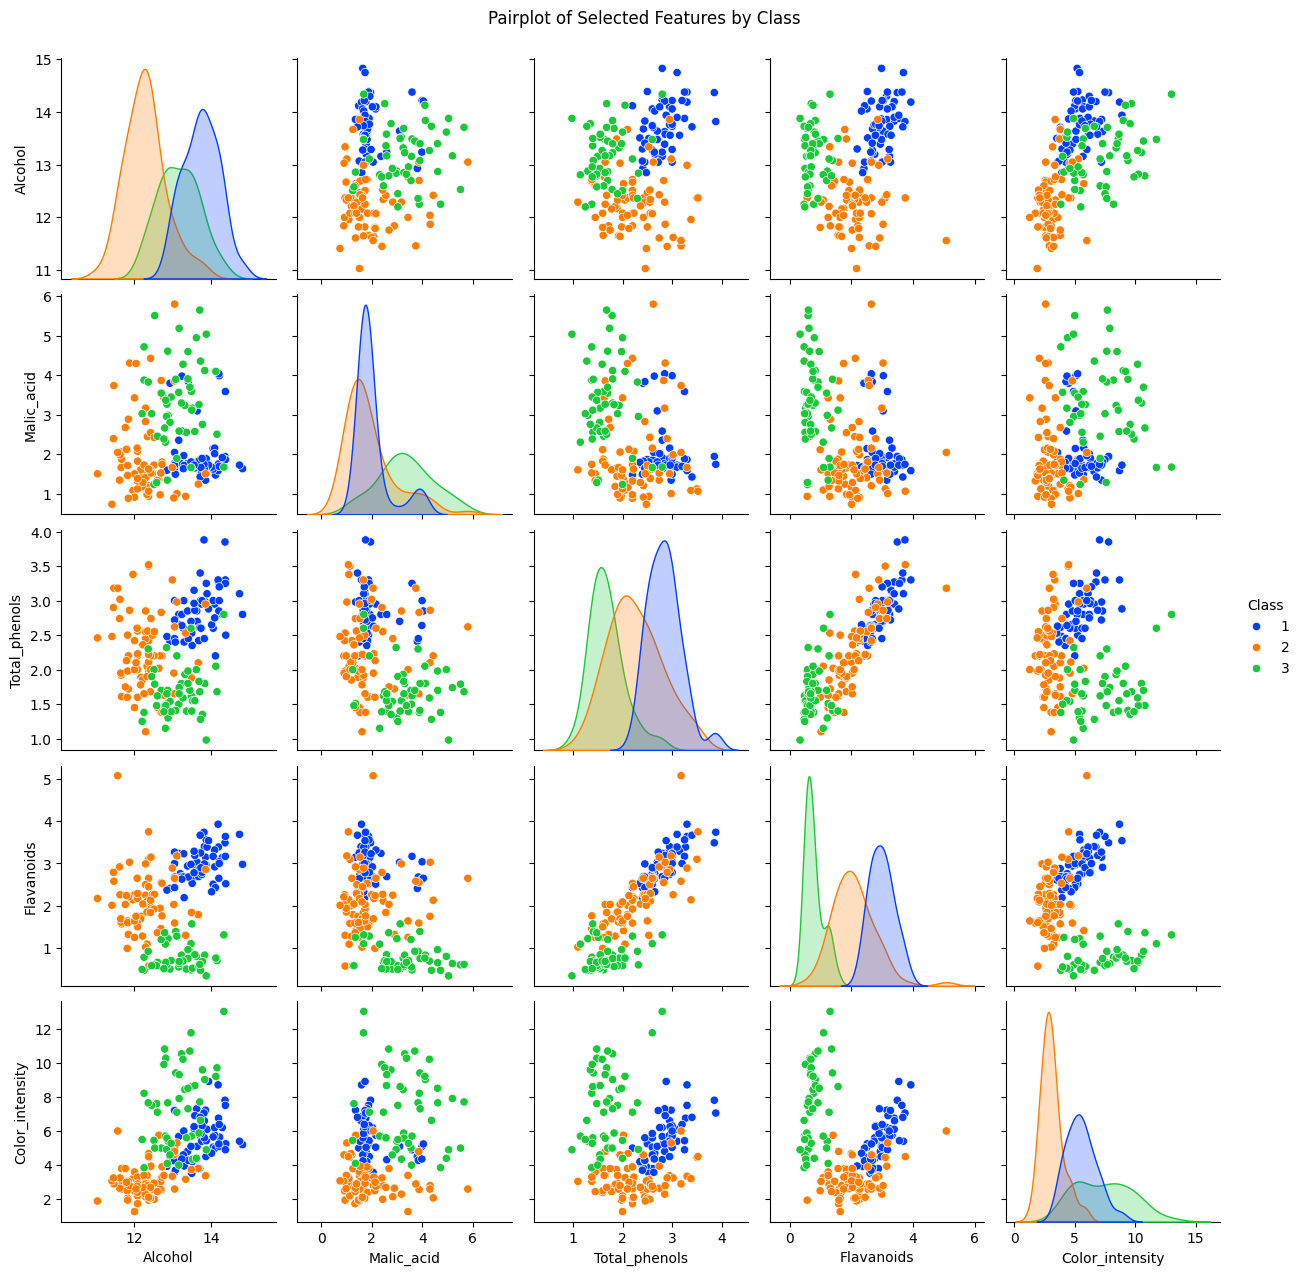

In [3]:
# Cek missing values
print("Missing Values:\n", data.isnull().sum())

# Analisis korelasi
correlation_matrix = data.corr()

# Heatmap korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Distribusi setiap fitur
selected_features = ["Alcohol", "Malic_acid", "Total_phenols", "Flavanoids", "Color_intensity", "Class"]
sns.pairplot(data[selected_features], hue="Class", diag_kind="kde", palette="bright")
plt.suptitle("Pairplot of Selected Features by Class", y=1.02)
plt.show()

In [5]:
# Split dataset menjadi fitur dan target
X = data.drop(columns=["Class"])
y = data["Class"]

# Split data menjadi train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standard Scaler
scaler = StandardScaler()

# Pipeline untuk berbagai model
pipelines = {
    "LogisticRegression": Pipeline([
        ("scaler", scaler),
        ("model", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "DecisionTree": Pipeline([
        ("model", DecisionTreeClassifier(random_state=42))
    ]),
    "KNeighbors": Pipeline([
        ("scaler", scaler),
        ("model", KNeighborsClassifier())
    ]),
    "XGBoost": Pipeline([
        ("model", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42))
    ])
}

# Hyperparameter grids
param_grids = {
    "LogisticRegression": {"model__C": [0.01, 0.1, 1, 10]},
    "DecisionTree": {"model__max_depth": [3, 5, 7, None]},
    "KNeighbors": {"model__n_neighbors": [3, 5, 7], "model__weights": ["uniform", "distance"]},
    "XGBoost": {"model__n_estimators": [50, 100, 150], "model__max_depth": [3, 5, 7]}
}

# Before fitting the model, adjust the class labels in y_train and y_test to start from 0:
y_train = y_train - 1
y_test = y_test - 1

# Tuning dan pelatihan
best_models = {}
for name, pipeline in pipelines.items():
    print(f"Tuning dan Training {name}...")
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train) # Now using the adjusted y_train
    best_models[name] = grid.best_estimator_
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Validation Accuracy: {grid.best_score_:.4f}\n")

Tuning dan Training LogisticRegression...
Best parameters for LogisticRegression: {'model__C': 0.1}
Validation Accuracy: 0.9931

Tuning dan Training DecisionTree...
Best parameters for DecisionTree: {'model__max_depth': 3}
Validation Accuracy: 0.9232

Tuning dan Training KNeighbors...
Best parameters for KNeighbors: {'model__n_neighbors': 5, 'model__weights': 'uniform'}
Validation Accuracy: 0.9650

Tuning dan Training XGBoost...
Best parameters for XGBoost: {'model__max_depth': 3, 'model__n_estimators': 50}
Validation Accuracy: 0.9443



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:08:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluating LogisticRegression on test data...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Evaluating DecisionTree on test data...
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.88      1.00      0.93        14
           2       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.96      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36

Evaluating KNeighbors on test data...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
     

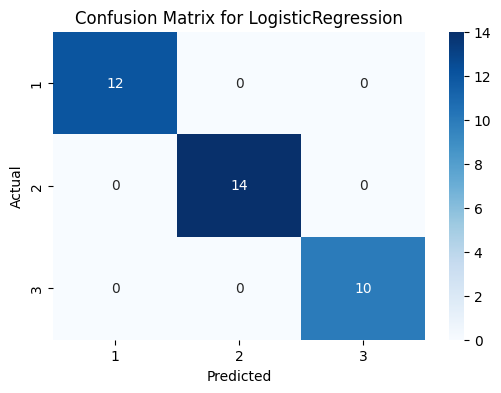

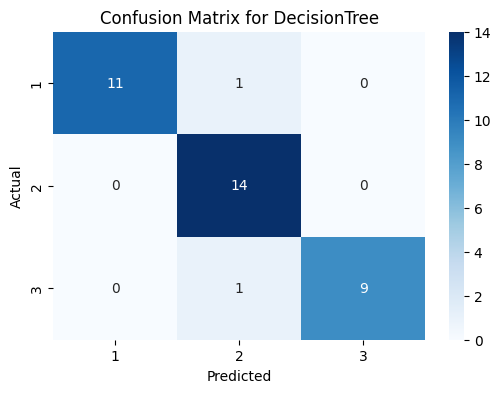

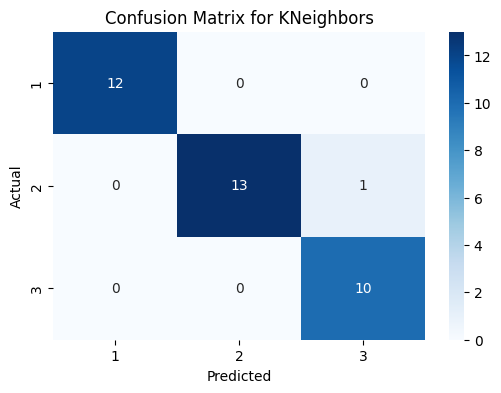

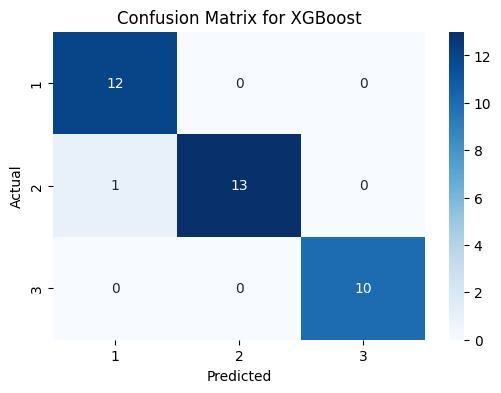

In [6]:
# Evaluasi pada test set
results = {}
for name, model in best_models.items():
    print(f"Evaluating {name} on test data...")
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report
    print(classification_report(y_test, y_pred))

# Visualisasi Confusion Matrix untuk setiap model
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [7]:
# Ringkasan hasil evaluasi
for name, metrics in results.items():
    accuracy = metrics["accuracy"]
    print(f"{name} Test Accuracy: {accuracy:.4f}")
    # Tambahkan analisis tambahan jika diperlukan


LogisticRegression Test Accuracy: 1.0000
DecisionTree Test Accuracy: 0.9444
KNeighbors Test Accuracy: 0.9722
XGBoost Test Accuracy: 0.9722
